In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '8'

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import matplotlib.pyplot as plt
import cv2
from PIL import Image

import mediapy as media
import PIL
import io

import matplotlib.patches
import seaborn as sns
from IPython.display import HTML as html_print


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
import sys
sys.path.append('../')
sys.path.append('../core')

from raft import RAFT
from train import get_args, load_model
import datasets as raft_datasets
import teachers
import utils.flow_viz as flow_viz
import matplotlib

def segmentation_to_rgb(seg, palette=None, num_objects=None, bg_color=(0, 0, 0)):
    if num_objects is None:
        num_objects = np.max(seg)  # assume consecutive numbering
    num_objects += 1  # background
    if palette is None:
        palette = [bg_color] + sns.color_palette('hls', num_objects-1)

    seg_img = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.float32)
    for i in range(num_objects):
        seg_img[np.nonzero(seg[:, :, 0] == i)] = palette[i]
    return seg_img

def depth_to_rgb(depth, colormap=matplotlib.cm.viridis_r, sqrt=True):
    cmap = np.array(colormap.colors)
    if sqrt:
        d = np.round(np.sqrt((depth[..., 0] / 65535).clip(0, 1.)) * 255).astype(np.uint8)
    else:
        d = np.round(depth[..., 0] // 256).astype(np.uint8)
    return cmap[d]

def flow_to_rgb(vec, flow_mag_range=None, white_bg=False):
    height, width = vec.shape[:2]
    scaling = 50. / (height**2 + width**2)**0.5
    direction = (np.arctan2(vec[..., 0], vec[..., 1]) + np.pi) / (2 * np.pi)
    norm = np.linalg.norm(vec, axis=-1)
    if flow_mag_range is None:
        flow_mag_range = norm.min(), norm.max()
        magnitude = np.clip((norm - flow_mag_range[0]) * scaling, 0., 1.)
    if white_bg == True:
        value = np.ones_like(direction)
        hsv = np.stack([direction, magnitude, saturation], axis=-1)
    else:
        saturation = np.ones_like(direction)
        hsv = np.stack([direction, saturation , magnitude], axis=-1)
        rgb = matplotlib.colors.hsv_to_rgb(hsv)
    return rgb

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
import sys
sys.path.append('../')
sys.path.append('../core')

from raft import RAFT
from train import get_args, load_model
import datasets as raft_datasets
import teachers
import utils.flow_viz as flow_viz
import matplotlib

def segmentation_to_rgb(seg, palette=None, num_objects=None, bg_color=(0, 0, 0)):
    if num_objects is None:
        num_objects = np.max(seg)  # assume consecutive numbering
    num_objects += 1  # background
    if palette is None:
        palette = [bg_color] + sns.color_palette('hls', num_objects-1)

    seg_img = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.float32)
    for i in range(num_objects):
        seg_img[np.nonzero(seg[:, :, 0] == i)] = palette[i]
    return seg_img

def depth_to_rgb(depth, colormap=matplotlib.cm.viridis_r, sqrt=True):
    cmap = np.array(colormap.colors)
    if sqrt:
        d = np.round(np.sqrt((depth[..., 0] / 65535).clip(0, 1.)) * 255).astype(np.uint8)
    else:
        d = np.round(depth[..., 0] // 256).astype(np.uint8)
    return cmap[d]

def flow_to_rgb(vec, flow_mag_range=None, white_bg=False):
    height, width = vec.shape[:2]
    scaling = 50. / (height**2 + width**2)**0.5
    direction = (np.arctan2(vec[..., 0], vec[..., 1]) + np.pi) / (2 * np.pi)
    norm = np.linalg.norm(vec, axis=-1)
    if flow_mag_range is None:
        flow_mag_range = norm.min(), norm.max()
        magnitude = np.clip((norm - flow_mag_range[0]) * scaling, 0., 1.)
    if white_bg == True:
        value = np.ones_like(direction)
        hsv = np.stack([direction, magnitude, saturation], axis=-1)
    else:
        saturation = np.ones_like(direction)
        hsv = np.stack([direction, saturation , magnitude], axis=-1)
        rgb = matplotlib.colors.hsv_to_rgb(hsv)
    return rgb

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
import dorsalventral.models.targets as targets
import dorsalventral.vis_utils as vis_utils
import dorsalventral.data as datasets
import dorsalventral.data.utils as data_utils
import dorsalventral.models.fire_propagation as fprop
import dorsalventral.models.layer_utils as layer_utils
import dorsalventral.models.segmentation.competition as competition
import dorsalventral.models.losses as losses
import kornia

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
# motion_paths = !ls ../checkpoints/[0-9]*motion*dtarg*nthr05*fullplay*pretrained*
# motion_paths = !ls ../checkpoints/[0-9]*motion*tdw*nthr0-cthr025*

# motion_paths = !ls ../checkpoints/[0-9]*motion*movi_d*bs2*nthr0-*gs1*
# motion_paths = !ls ../checkpoints/[0-9]*motion*rnd1*movi_d*bs2*gs1*
motion_paths = !ls ../checkpoints/100000*motion*rnd1*movi_d*bs2*small*gs1*

motion_paths = sorted(motion_paths, key=lambda s: int(s.split('/')[-1].split('_')[0]))
# !ls ../checkpoints/*motion*imtarg*thr0*
for i,p in enumerate(motion_paths):
    print(i, p)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0 ../checkpoints/100000_motion-rnd1-movi_d-bs2-small-mt05-bt05-flit24-gs1-pretrained-0.pth


In [12]:
# boundary_paths = !ls ../checkpoints/[0-9]*boundary*rnd1*dtarg*fullplay*pretrained*

# boundary_paths = !ls ../checkpoints/[0-9]*boundaryStaticReg*rnd0*cthr075*fullplay*rerun*
# boundary_paths = !ls ../checkpoints/[0-9]*boundaryMotionReg*rnd0*small*nthr0*cthr075*fullplay*
# boundary_paths = !ls ../checkpoints/[0-9]*boundaryMotionReg*rnd1*tdw*small*

# boundary_paths = !ls ../checkpoints/[0-9]*boundaryStatic*rnd0*movi_d*nthr0-*gs1*
# boundary_paths = !ls ../checkpoints/100000*boundaryMotion*rnd0*movi_d*nthr0-*gs1*

boundary_paths = !ls ../checkpoints/100000*boundaryMotion*rnd1*movi_d*small*gs1*-1*
# boundary_paths = !ls ../checkpoints/100000*boundaryMotion*rnd0*movi_d*gs1*


boundary_paths = sorted(boundary_paths, key=lambda s: int(s.split('/')[-1].split('_')[0]))
for i,p in enumerate(boundary_paths):
    print(i, p)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0 ../checkpoints/100000_boundaryMotionReg-rnd1-movi_d-bs2-small-mt05-bt05-flit24-gs1-pretrained-1.pth


In [13]:
# flow_paths = !ls ../checkpoints/[0-9]*flowBoundary*bmt*movi_d*gs1*
# flow_paths = !ls ../checkpoints/[0-9]*flowBoundary*rnd0*movi_d*gs1*
# flow_paths = !ls ../checkpoints/[0-9]*flowBoundary*rnd1*movi_d*large*gs1*
flow_paths = !ls ../checkpoints/100000*flowBoundary*rnd1*movi_d*small*gs1*
# flow_paths = !ls ../checkpoints/[0-9]*flowCentroids*rnd2*movi_d*small*gs1*

# flow_paths = !ls ../checkpoints/[0-9]*flowBoundary*tdw*
# flow_paths = !ls ../checkpoints/100000*flowBoundary*rnd0*movi_d*gs1*


flow_paths = sorted(flow_paths, key=lambda s: int(s.split('/')[-1].split('_')[0]))
# !ls ../checkpoints/*motion*imtarg*thr0*
for i,p in enumerate(flow_paths):
    print(i, p)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0 ../checkpoints/100000_flowBoundary-rnd1-movi_d-bs2-small-mt05-bt05-flit24-gs1-pretrained-0.pth
1 ../checkpoints/100000_flowBoundary-rnd1-movi_d-bs2-small-mt05-bt05-flit24-gs1-pretrained-1.pth


In [14]:
# e_path = '../checkpoints/80000_eisen_teacher_v1_128_bs4.pth'
e_path = '../checkpoints/30000_eisen_teacher_v1_64_bs16.pth'

print(e_path)

../checkpoints/30000_eisen_teacher_v1_64_bs16.pth


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
m_idx = -1
b_idx = -1
f_idx = -1
m_path = motion_paths[m_idx]
b_path = boundary_paths[b_idx]
f_path = flow_paths[f_idx]
boot_paths = {
    'motion_path': m_path,
    'boundary_path': b_path,
    'flow_path': f_path
}


stride = 4
T_group = 4
T_track = 2
T = 6
use_gt = False
use_eisen = False
if use_eisen:
    static_path = e_path
elif use_gt:
    static_path = 'ground_truth'
else:
    static_path = None

BBNet = teachers.BipartiteBootNet(
#     student_model_type='flow_centroids',
#     target_model_params={},
    static_path=static_path,
#     static_params={'radius': 7},
    static_params={'stem_pool': (stride == 4), 'affinity_res': [256//stride,256//stride]},
    input_keys={'static': 'objects'} if use_gt else {},
    boot_paths=boot_paths,
    downsample_factor=stride,
    grouping_window=T_group,
    tracking_step_size=T_track,
    static_resolution=4,
    dynamic_resolution=3
).cuda().eval()


data_dir = '/mnt/fs6/honglinc/dataset/tensorflow_datasets/movi_d/256x256/1.0.0'
movi_dataset = datasets.movi.MoviDataset(
    dataset_dir=data_dir,
    split='validation',
    sequence_length=T,
    min_start_frame=12-(T//2),
    max_start_frame=12-(T//2),
    is_test=False
)
print(len(movi_dataset))

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Plateau map dimensions: [stat 16, dyn 9, rand 0, total 144]
<All keys matched successfully> MotionClassifier ../checkpoints/100000_motion-rnd1-movi_d-bs2-small-mt05-bt05-flit24-gs1-pretrained-0.pth
<All keys matched successfully> BoundaryClassifier ../checkpoints/100000_boundaryMotionReg-rnd1-movi_d-bs2-small-mt05-bt05-flit24-gs1-pretrained-1.pth
<All keys matched successfully> RAFT ../checkpoints/100000_flowBoundary-rnd1-movi_d-bs2-small-mt05-bt05-flit24-gs1-pretrained-1.pth


In [ ]:
ex = 0
# data = movi_eval_dataset[ex]
for e in range(ex+1):
    data = movi_dataset[e]
video = data['images']
print("video", video.shape)
# preds, plateau, segments, full_segments = BBNet(video[None].cuda())
stitch_segments = []
windows = [[0,4],[2,6]]
for w in windows:
    bbnet_preds = BBNet(
    #     video[None].cuda(),
        {k:data[k][None][:,w[0]:w[1]].cuda() for k in ['images', 'objects']},
        boot_params={'bootstrap': False, 'flow_iters': 12},
        static_params={'to_image': True, 'local_window_size': None},
        mask_with_motion=True
    )
    if BBNet.student_model_type is None:
        preds, plateau, segments, full_segments = bbnet_preds
        mask = preds[-1][:,:,0,...,None]
        stitch_segments.append(full_segments)
    elif BBNet.student_model_type in ['flow', 'flow_centroids']:
        s2m_target = bbnet_preds
    elif BBNet.student_model_type in ['centroids']:
        dcentroid_target, thingness = bbnet_preds


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


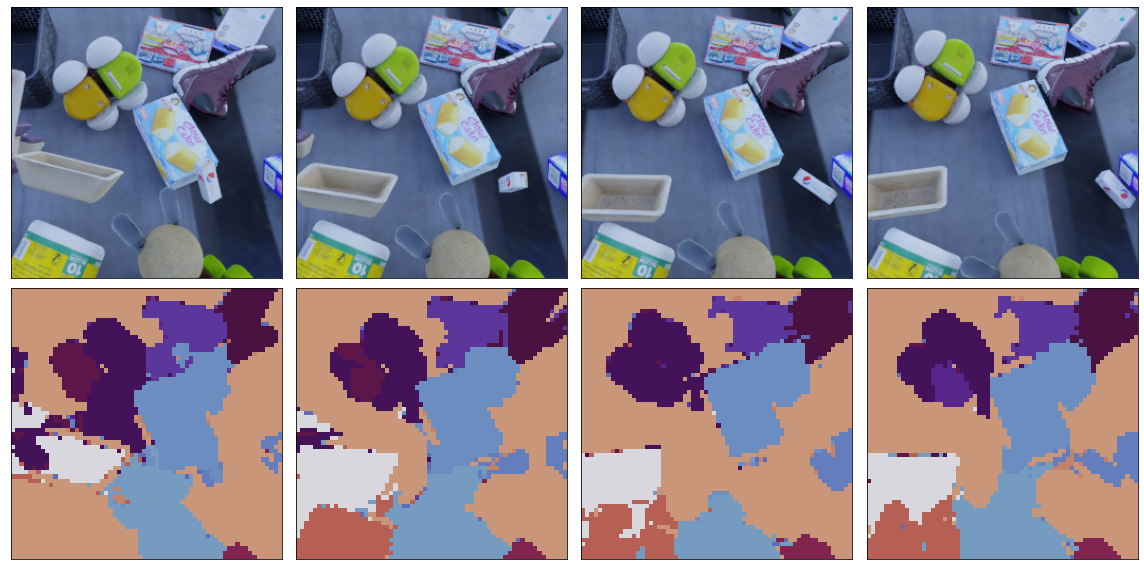

In [172]:
T_full = full_segments.shape[1]
fig, axes = plt.subplots(2,T_full, figsize=(4*T_full, 8))
for t in range(T_full):
    vis_utils.imshow(data['images'][None,t], axes[0][t])
    vis_utils.imshow(full_segments[:,t,None], axes[1][t], cmap='twilight', vmin=-1, vmax=33)
    for ax in axes[:,t]:
        ax.set_xticks([])
        ax.set_yticks([])
plt.tight_layout()
plt.show()

In [183]:
import dorsalventral.evaluation.object_metrics as om
T_eval = T
segments_rz = transforms.Resize([256,256], interpolation=transforms.InterpolationMode.NEAREST)(full_segments)
print(T_eval, segments_rz.shape)
ari = om.adjusted_rand_index(
    pred_ids=(full_segments[:,:T_eval]+1).long(),
    true_ids=data['objects'][None,:T_eval,0,::BBNet.stride,::BBNet.stride].long().cuda(),
    num_instances_pred=(full_segments[:,:T_eval]+1).amax().item()+1,
    num_instances_true=data['objects'][:T_eval].amax().item()+1,
    ignore_background=True
)
print(ari)

ari = om.adjusted_rand_index(
    pred_ids=(segments_rz[:,:T_eval]+1).long(),
    true_ids=data['objects'][None,:T_eval,0].long().cuda(),
    num_instances_pred=(segments_rz[:,:T_eval]+1).amax().item()+1,
    num_instances_true=data['objects'][:T_eval].amax().item()+1,
    ignore_background=True
)
print(ari)

4 torch.Size([1, 4, 256, 256])
tensor([0.6239], device='cuda:0')
tensor([0.6208], device='cuda:0')


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [178]:
### ex 0 MoviD

### middle 6 frames
# Tgroup = 2: 0.42
# Tgroup = 3: 0.53
# Tgroup = 4: 0.61
# Tgroup = 5: 0.63
# Tgroup = 6: 0.65

# Tgroup = 4, Ttrack = 2: 0.71

### middle 8 frames
# Tgroup = 6: 0.52
# Tgroup = 8: 0.56

# Tgroup = 6, Ttrack = 2: 0.49

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [179]:
stitched = BBNet.stitch_segment_movies(full_segments[:,0:2], full_segments[:,2:4] + 5)

torch.Size([1, 1, 64, 64, 29]) torch.Size([1, 1, 64, 64, 34]) torch.Size([1, 29, 34])


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


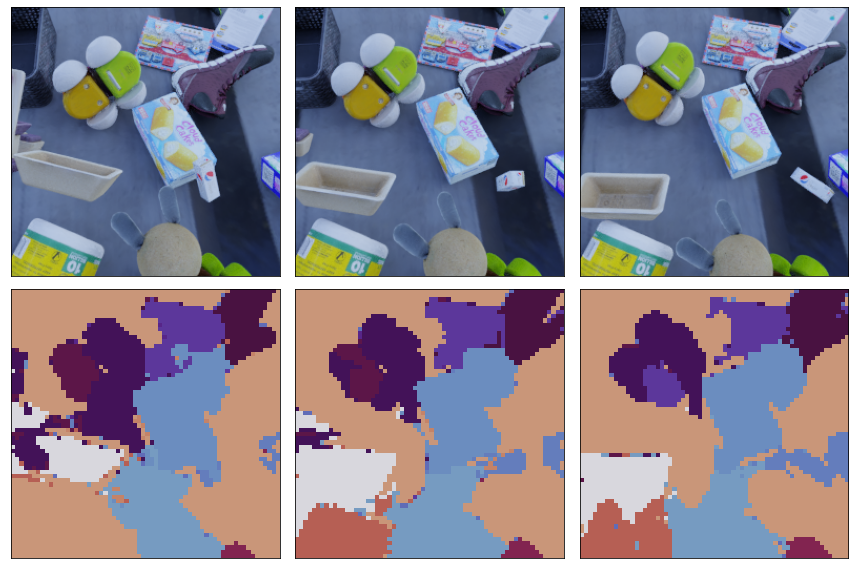

In [182]:
T_full = stitched.shape[1]
fig, axes = plt.subplots(2,T_full, figsize=(4*T_full, 8))
for t in range(T_full):
    vis_utils.imshow(data['images'][None,t], axes[0][t])
    vis_utils.imshow(stitched[:,t,None], axes[1][t], cmap='twilight', vmin=-1, vmax=33)
    for ax in axes[:,t]:
        ax.set_xticks([])
        ax.set_yticks([])
plt.tight_layout()
plt.show()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


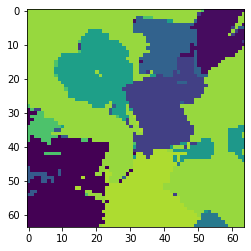

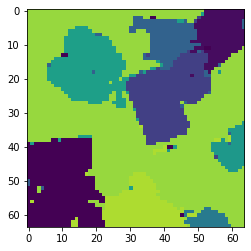

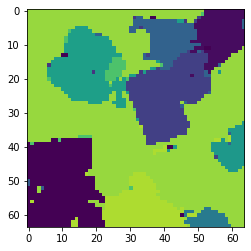

In [165]:
vis_utils.imshow(full_segments[:,1:2], vmin=0, vmax=32)
vis_utils.imshow(segs2_stitch[:,0:1], vmin=0, vmax=32)
vis_utils.imshow(full_segments[:,2:3], vmin=0, vmax=32)


In [118]:
parents_of_segs2 = scores.argmax(-1)
parents_of_segs2

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


tensor([[ 0,  1,  0,  0,  0, 18,  6,  0,  0,  0, 10,  0,  0, 13,  0,  0,  0, 17,
         18,  0,  0,  0,  0, 27,  0,  0,  0, 27, 28]], device='cuda:0')

In [122]:
scores[0,parents_of_segs2,torch.arange(parents_of_segs2.shape[-1], dtype=torch.long, device=scores.device)]

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


tensor([[0.7549, 0.7672, 0.0000, 0.0000, 0.0000, 0.0026, 0.6848, 0.0000, 0.0000,
         0.0036, 0.6550, 0.0000, 0.0000, 0.5263, 0.0000, 0.0000, 0.0000, 0.2568,
         0.6093, 0.0000, 0.0000, 0.0000, 0.0000, 0.0048, 0.0000, 0.0000, 0.0000,
         0.6729, 0.5734]], device='cuda:0')

In [124]:
fs = full_segments[0,0]
torch.unique(fs)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


tensor([ 0,  1,  5,  6,  9, 10, 13, 17, 18, 23, 27, 28], device='cuda:0')

In [125]:
fs[fs == 1] = 30
torch.unique(fs)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


tensor([ 0,  5,  6,  9, 10, 13, 17, 18, 23, 27, 28, 30], device='cuda:0')

In [ ]:
# each mask in segs2 needs to have a parent in segs1
# if a mask in segs2 has two parents in segs1, go with the higher miou
# if two masks in segs2 have the same parent in segs1, either one has to die or they have to merge

In [127]:
for i in list(torch.unique(fs)):
    fs[fs == i] = 42 + i
torch.unique(fs)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


tensor([42, 47, 48, 51, 52, 55, 59, 60, 65, 69, 70, 72], device='cuda:0')